# Deploying trained Le Net model

In [2]:
%matplotlib inline
import numpy as np

caffe_root = '../../../caffe/'

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

/home/mily/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import os
np_loaded_data_file = '../data/train_data_cleaned.npz'
if not os.path.isfile(np_loaded_data_file):
    print "%s does not exist. See facial_recog_kaggle.ipynb" % np_loaded_data_file
else:
    print "loading %s" % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    print "loaded: ", npzfile.files
    X_train_clean_cv, y_train_clean_cv = npzfile['X_train_clean_cv'], npzfile['y_train_clean_cv']
    X_val_clean_cv, y_val_clean_cv = npzfile['X_val_clean_cv'], npzfile['y_val_clean_cv']
    feature_labels = npzfile['feature_labels']
    print X_train_clean_cv.shape, y_train_clean_cv.shape
    print X_val_clean_cv.shape, y_val_clean_cv.shape


loading ../data/train_data_cleaned.npz
loaded:  ['X_val_clean_cv', 'y_val_clean_cv', 'y_train_clean_cv', 'feature_labels', 'X_train_clean_cv']
(1640, 1, 96, 96) (1640, 30)
(500, 1, 96, 96) (500, 30)


In [4]:
net = caffe.Net('test_net.prototxt',
                'lenet_trained.caffemodel',
                caffe.TEST)

## Sanity Checks

In [5]:
[(k, v[0].data.shape, v[1].data.shape) for k, v in net.params.items()]

[('conv1', (20, 1, 5, 5), (20,)),
 ('conv2', (50, 20, 5, 5), (50,)),
 ('fc1', (500, 22050), (500,)),
 ('score', (30, 500), (30,))]

In [19]:
def euclidean_loss(a, b):
    batch_size, num_labels = a.shape
    
    return np.sum((a-b)**2) / float(num_labels * 2)
    
# Make sure train error and validation error are as expected. 
train_size = X_train_clean_cv.shape[0]
val_size = X_val_clean_cv.shape[0]
num_labels = y_train_clean_cv.shape[1]

train_error = 0
num_batches = 10
batch_size = 128
out_train_clean_cv = np.zeros_like(y_train_clean_cv)
for it in range(num_batches):
    it_range = range(it*batch_size,it*batch_size+batch_size)
    net.blobs['data'].data[...] = X_train_clean_cv[it_range]
    net.forward()
    out = net.blobs['score'].data
    out_train_clean_cv[it_range, :] = out
    
    train_error += euclidean_loss(out, y_train_clean_cv[it_range])
train_error = train_error / float(num_batches * batch_size)  

print train_error



23.432554706


In [20]:
num_batches = 3
batch_size = 128
val_error = 0
out_val_clean_cv = np.zeros_like(y_val_clean_cv)

for it in range(num_batches):
    it_range = range(it*batch_size,it*batch_size+batch_size)
    net.blobs['data'].data[...] = X_val_clean_cv[it_range]
    net.forward()
    out = net.blobs['score'].data
    out_val_clean_cv[it_range, :] = out
    
    val_error += euclidean_loss(out, y_val_clean_cv[it_range])
val_error = val_error / float(num_batches * batch_size)  
print val_error

23.396957585


[[ 774 1450 1457  229]
 [ 111   44  841 1567]
 [ 955  670  828  851]
 [ 503  732  910 1496]]


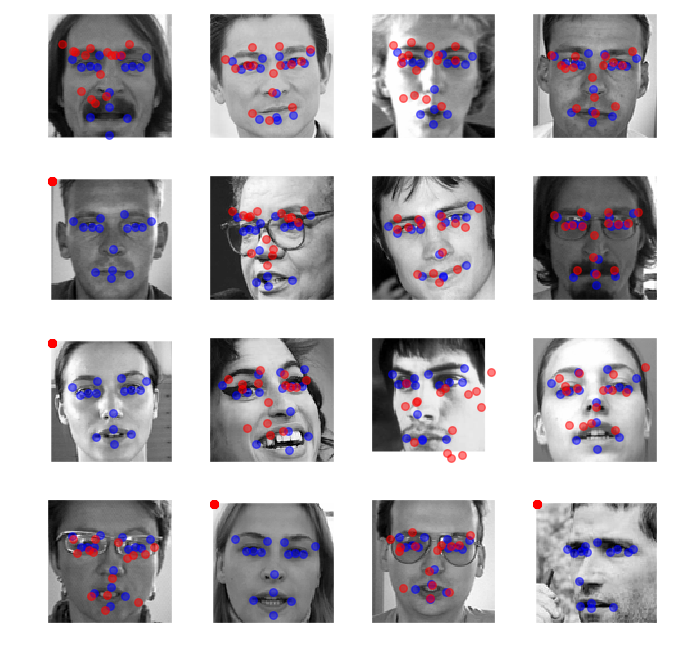

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Visualize
N_img_x = 4
N_img_y = 4
sel_idx = np.random.choice(X_train_clean_cv.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_train_clean_cv[i].reshape(96, 96)
        b = y_train_clean_cv[i]
        b_x = b[0::2]
        b_y = b[1::2]
        
        o = out_train_clean_cv[i]
        o_x = o[0::2]
        o_y = o[1::2]
        

        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(a)
        plt.scatter(b_x, b_y, s=30, alpha=0.5, color='blue')
        plt.scatter(o_x, o_y, s=30, alpha=0.5, color='red')
        plt.gca().axis('off')
plt.show()

[[ 31 104 382 168]
 [423 485  28 155]
 [435 459 448 339]
 [351 496 241   9]]


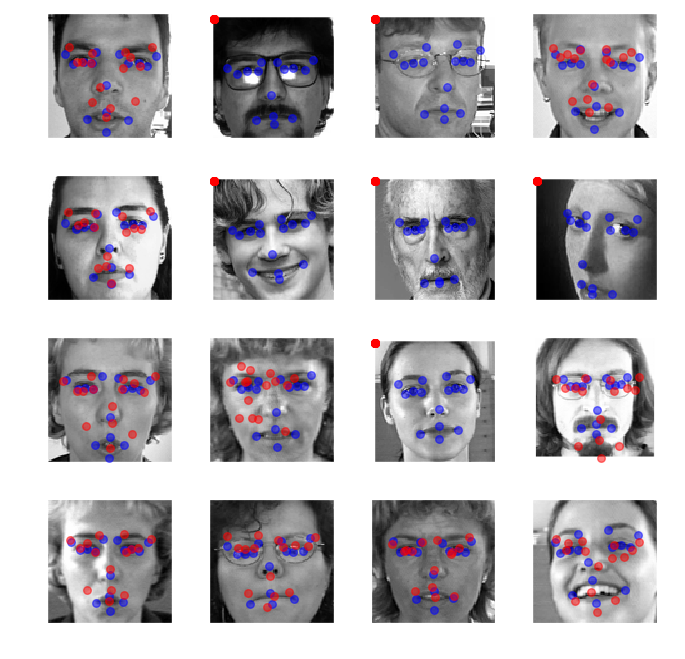

In [24]:
# Visualize
N_img_x = 4
N_img_y = 4
sel_idx = np.random.choice(X_val_clean_cv.shape[0], N_img_x * N_img_y, replace=False).reshape(N_img_x, N_img_y)
print sel_idx

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
for n_y in range(N_img_y):
    for n_x in range(N_img_x):
        i = sel_idx[n_x][n_y]
        a = X_val_clean_cv[i].reshape(96, 96)
        b = y_val_clean_cv[i]
        b_x = b[0::2]
        b_y = b[1::2]
        
        o = out_val_clean_cv[i]
        o_x = o[0::2]
        o_y = o[1::2]
        

        plt.subplot(N_img_x, N_img_y, n_y * N_img_x + n_x + 1)
        plt.imshow(a)
        plt.scatter(b_x, b_y, s=30, alpha=0.5, color='blue')
        plt.scatter(o_x, o_y, s=30, alpha=0.5, color='red')
        plt.gca().axis('off')
plt.show()